# C1 - Introduction to Human and Computer Vision
## Week 4

In [1]:
import os
import re
import matplotlib.pyplot as plt
import cv2
import pickle
import numpy as np

# Get project's root directory
BASE_PATH = os.path.join(re.search(r'.+(Team5)', os.getcwd())[0], 'week4')
os.chdir(BASE_PATH)
BASE_PATH

DATA_DIRECTORY = '../data'

In [2]:
# Read pickle file to see detailed info of the images augmentation
with open(f'{DATA_DIRECTORY}/qsd1_w4/augmentations.pkl', 'rb') as f:
    augmentations_info = pickle.load(f)

# Read pickle file with correspondences
with open(f'{DATA_DIRECTORY}/qsd1_w4/gt_corresps.pkl', 'rb') as f:
    ground_truth = pickle.load(f)

### a) Remove background, detect noise (and filter it)

In [3]:
from src.background_removal import background_removal
from src.noise_removal import denoise_image
from tqdm import tqdm

# Image names
QSD1_w4_names = [f for f in os.listdir(f'{DATA_DIRECTORY}/qsd1_w4/') if f.endswith('.jpg')]
QSD1_w4_names.sort()

# Initialize datasets
BBDD = []
QSD1_w4 = []
QSD1_w4_filtered = []
QSD1_w4_nonAugmented = []

# Load datasets (+ filter)
for image_name in tqdm(QSD1_w4_names):
    # Read QSD1_w4
    image_qsd1 = cv2.imread(f'{DATA_DIRECTORY}/qsd1_w4/{image_name}')
    QSD1_w4.append(image_qsd1)

    # Read non-augmented image
    # image_nonAugmented = cv2.imread(f'{DATA_DIRECTORY}/qsd1_w4/non_augmented/{image_name}')
    # image_nonAug_bckg_remov = background_removal(image_nonAugmented)  # Remove background in non-augmented image
   
    # QSD1_w4_nonAugmented.append(image_nonAug_bckg_remov)

    # Filter image from QSD1_w4
    filtered_image = background_removal(denoise_image(image_qsd1))  # Detect noise (and clean it) + Remove background
    QSD1_w4_filtered.append(filtered_image)


# Read BBDD
BBDD_names = [f for f in os.listdir(f'{DATA_DIRECTORY}/BBDD/') if f.endswith('.jpg')]
BBDD_names.sort()

for image_name in tqdm(BBDD_names):
    image_bbdd = cv2.imread(f'{DATA_DIRECTORY}/BBDD/{image_name}')
    BBDD.append(image_bbdd)

100%|██████████| 287/287 [00:05<00:00, 53.00it/s]


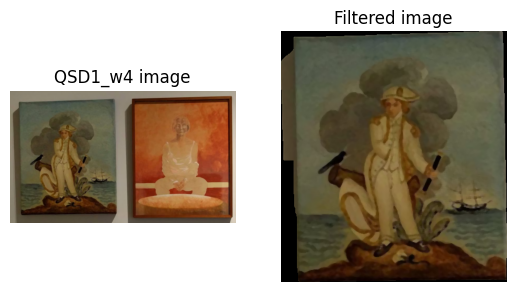

In [4]:
# Plot some examples
img_number = 2


fig, axes = plt.subplots(1, 2)  # 1 fila, 3 columnas

# QSD1_w4 image
image = QSD1_w4[img_number]
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
axes[0].imshow(image)
axes[0].set_title('QSD1_w4 image')
axes[0].axis('Off')

# Filtered image (background removal + denoise)
image = QSD1_w4_filtered[img_number][0]
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
axes[1].imshow(image)
axes[1].set_title('Filtered image')
axes[1].axis('Off')

# Non-augmented image
# image = QSD1_w4_nonAugmented[img_number][0]
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# axes[2].imshow(image)
# axes[2].set_title('Non-augmented image')
# axes[2].axis('Off')

plt.show()
plt.close()

### b) Detect keypoints and compute descriptors

In [5]:
'''
flags = {
  DEFAULT = 0,
  DRAW_OVER_OUTIMG = 1,
  NOT_DRAW_SINGLE_POINTS = 2,
  DRAW_RICH_KEYPOINTS = 4
}
'''
def draw_keypoints(image, kp, flags=0):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img2 = cv2.drawKeypoints(gray_image, kp, None,(255,0,0),flags=flags)
    plt.imshow(img2) 

#### SIFT

In [6]:
def sift_descriptor(image, params={}):
    '''
    Compute SIFT descriptors for a given image
    :param image: image to compute the descriptors
    :param params: parameters for the SIFT algorithm
    :return: keypoints and descriptors

    default params = {
        'nfeatures': 0,
        'nOctaveLayers': 3,
        'contrastThreshold': 0.04,
        'edgeThreshold': 10,
        'sigma': 1.6
    }
  
    '''
    # img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create(**params)
    kp, des = sift.detectAndCompute(image, None)

    return (kp, des)

In [7]:
# Reshape all images to 256x256
QSD1_w4 = [cv2.resize(image, (256, 256)) for image in QSD1_w4]
BBDD = [cv2.resize(image, (256, 256)) for image in BBDD]
# For QSD1_w4_filtered, each element is a list of images
QSD1_w4_filtered = [[cv2.resize(image, (256, 256)) for image in images] for images in QSD1_w4_filtered]

In [8]:

params = {
    'nfeatures': 1000,
}

sift_query = []
for picture in tqdm(QSD1_w4_filtered):
    res = []
    for painting in picture:
        kp, des = sift_descriptor(painting, params=params)
        res.append({'kp': kp, 'des': des})
    sift_query.append(res)


sift_bd = []
for painting in tqdm(BBDD):
    kp, des = sift_descriptor(painting, params=params)
    sift_bd.append({'kp': kp, 'des': des})

100%|██████████| 287/287 [00:04<00:00, 59.71it/s]


In [9]:
idx1 = 6 # Query image
idx2 = ground_truth[6][0] # BBDD image

des1 = sift_query[idx1][0]['des']
des2 = sift_bd[idx2]['des']

Distance: 213.59006417536102


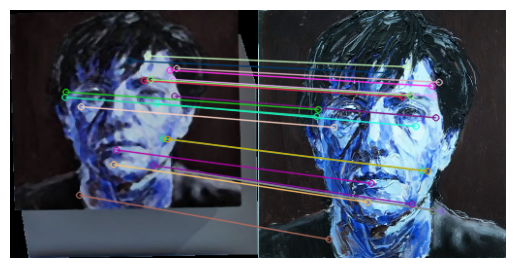

(<matplotlib.image.AxesImage at 0x718a308f8350>,
 (np.float64(-0.5), np.float64(511.5), np.float64(255.5), np.float64(-0.5)),
 None)

In [10]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
# Match descriptors.
matches = bf.match(des1,des2)
# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)
# Draw first 10 matches.
img3 = cv2.drawMatches(
    QSD1_w4_filtered[idx1][0], sift_query[idx1][0]['kp'],
    BBDD[idx2], sift_bd[idx2]['kp'],
    matches[:20], None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
print('Distance:', np.mean([m.distance for m in matches]))
plt.imshow(img3), plt.axis('off'), plt.show()

In [11]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

res = []
dist_res = []
# Matrix of size 30xN where N is the number of images in the BBDD
for i in tqdm(range(30)):
    picture_res = []
    picture_distances = []
    for j in range(0, len(sift_query[i])):
        distances = []
        for k in range(0, len(sift_bd)):
            if sift_bd[k]['des'] is not None:
                matches = bf.match(sift_query[i][j]['des'], sift_bd[k]['des'])
                matches = sorted(matches, key = lambda x:x.distance)
                distance = np.mean([match.distance for match in matches[:20]])
                distances.append(distance)
            else:
                distances.append(10000)

        # Take top 10 matches
        most_similar = np.argsort(distances)[:10]
        most_similar_distances = [distances[idx] for idx in most_similar]
        picture_res.append(most_similar)
        picture_distances.append(most_similar_distances)
    
    res.append(picture_res)
    dist_res.append(picture_distances)


100%|██████████| 30/30 [00:22<00:00,  1.34it/s]


In [72]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import hmean

# Assuming `sift_query`, `sift_bd`, and `ground_truth` are defined with the proper structure
dist_res = []
colors = []  # New list to store color based on ground_truth
res = []

# Modify the loop to populate dist_res and colors
for i in tqdm(range(30)):
    picture_distances = []
    picture_most_similar = []
    for j in range(0, len(sift_query[i])):
        distances = []
        for k in range(0, len(sift_bd)):
            if sift_bd[k]['des'] is not None:
                descriptors1 = sift_query[i][j]['des']
                keypoints1 = sift_query[i][j]['kp']
                descriptors2 = sift_bd[k]['des']
                keypoints2 = sift_bd[k]['kp']

                # Use BFMatcher to match descriptors
                bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
                matches = bf.match(descriptors1, descriptors2)

                # Sort matches by distance and select the top 20 most similar matches
                matches = sorted(matches, key=lambda x: x.distance)[:10]

                if len(matches) < 10:
                    distances.append(10000)
                    continue

                # Extract the matched keypoints' coordinates for the top 10 matches
                matched_points_img1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
                matched_points_img2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])

                # Calculate the relative positions in both images
                relative_positions = matched_points_img2 - matched_points_img1

                distances.append(np.mean(np.linalg.norm(relative_positions, axis=1)))
            else:
                distances.append(10000)
            
        # Take top 10 matches
        most_similar_distances = [distances[idx] for idx in np.argsort(distances)[:10]]
        picture_distances.append(most_similar_distances)

        if (most_similar_distances[1] - most_similar_distances[0]) / most_similar_distances[0] < 0.3:
            picture_most_similar.append([-1])
        else:
            picture_most_similar.append(np.argsort(distances)[:10])
        
        # Determine color based on ground_truth[i]
        if ground_truth[i] == [-1]:
            colors.append('red')
        else:
            colors.append('blue')
    
    dist_res.append(picture_distances)
    res.append(picture_most_similar)

100%|██████████| 30/30 [00:30<00:00,  1.02s/it]


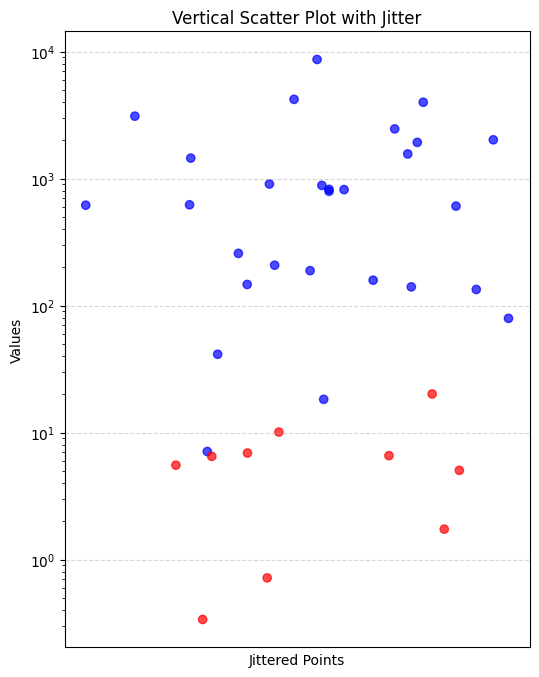

In [73]:
# Once `dist_res` and `colors` are populated, calculate values for the scatter plot
values = []
for i in range(len(dist_res)):
    for j in range(len(dist_res[i])):
        values.append((dist_res[i][j][1] - dist_res[i][j][0]) / dist_res[i][j][0] * 100)

# Add jitter to x-axis
x_jitter = np.random.normal(0, 0.05, size=len(values))  # Adjust 0.05 for desired jitter
x_values = 1 + x_jitter  # Center around x=1 for vertical plot

# Plot
plt.figure(figsize=(6, 8))
plt.scatter(x_values, values, c=colors, alpha=0.7)
plt.xlabel('Jittered Points')
plt.ylabel('Values')
plt.title('Vertical Scatter Plot with Jitter')
plt.xticks([])  # Hide x-ticks for a cleaner look
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
# log y axis
plt.yscale('log')
plt.show()


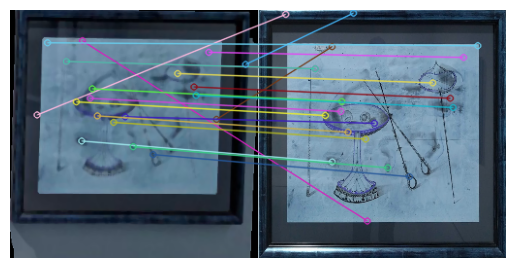

Distance: 146.72498512268066
50.432114


In [74]:
import cv2
import numpy as np

i, j, k = 18, 1, ground_truth[18][1]

descriptors1 = sift_query[i][j]['des']
keypoints1 = sift_query[i][j]['kp']
descriptors2 = sift_bd[k]['des']
keypoints2 = sift_bd[k]['kp']

# Use BFMatcher to match descriptors
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)

# Sort matches by distance and select the top 10 most similar matches
matches = sorted(matches, key=lambda x: x.distance)[:20]

# Extract the matched keypoints' coordinates for the top 10 matches
matched_points_img1 = np.float32([keypoints1[m.queryIdx].pt for m in matches])
matched_points_img2 = np.float32([keypoints2[m.trainIdx].pt for m in matches])

# Calculate the relative positions in both images
relative_positions = matched_points_img2 - matched_points_img1

img3 = cv2.drawMatches(
    QSD1_w4_filtered[i][j], sift_query[i][j]['kp'],
    BBDD[k], sift_bd[k]['kp'],
    matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
plt.imshow(img3), plt.axis('off'), plt.show()

print('Distance:', np.mean([m.distance for m in matches]))
print(np.mean(np.linalg.norm(relative_positions, axis=1)))

In [75]:
import importlib
import src.metrics  # re-import the module to make sure it's recognized
importlib.reload(src.metrics)

from src.metrics import mapk

# Now you can call the updated mapk function
mapk(ground_truth, res, k=1)


-1 [-1]
150 [150 187 124 267 179 175 159  17 214 191]
48 [ 48  15 270  67  20  30  13 135 201 226]
251 [251 153  62  78 196  71  11 203 127  85]
32 [ 32 162 152  53 136  71  55 118 200 232]
161 [161 172   6 185 284 124 163 135  30  33]
81 [ 81  72  15 153 124 250 107 129 191 132]
62 [ 62  30 183  90 214 235 125 270 123 179]
38 [ 38 154  65   2  91  20 244  49  48 209]
-1 [-1]
128 [-1]
155 [155 190  90 207 250 191  62  37 268  86]
258 [258 240 158 219  17 164  75  35  67   4]
136 [136 166   7 198 185 274  30 255  71 269]
76 [ 76 155  56  20  57  15 272 211 175  90]
-1 [-1]
-1 [-1]
53 [-1]
-1 [-1]
12 [ 12 124  46 111 200 179 135  20 282 114]
11 [-1]
280 [280   4 243 284 151 191 118 250  30  61]
-1 [-1]
182 [182  74 240 136 280 270  41   9 165 194]
252 [252  52  22 107  30 129 221 250 155  92]
-1 [-1]
272 [272 151  20  90 243 185  81 224  71 219]
117 [117  30  71 171  66 134  53 129 219 207]
-1 [-1]
242 [242 267 214 179 124 220  37  42 169   8]
260 [260 284 207 124 170 213 199  46  30  90

np.float64(0.9230769230769231)

#### HOG

In [70]:
from skimage.feature import hog
from skimage import exposure
from scipy.spatial.distance import euclidean
import importlib

import src.metrics 
importlib.reload(src.metrics)
from src.metrics import mapk

params={
    'shape': (100,100),  # Shape we want to resize the image to
    'pixels_per_cell': (18,18),
    'cells_per_block': (3,3),
}

def hog_descriptor(image, shape: tuple, pixels_per_cell: tuple, cells_per_block: tuple):
    
    # Image to grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize image (we need same dimensions in all the image descriptros to compare)
    image = cv2.resize(image, shape, interpolation=cv2.INTER_AREA)

    # Compute HOG
    hog_descriptor, hog_image = hog(image, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=True)
    
    # Rescale intensity, otherwise we may see everyhing black
    hog_image = exposure.rescale_intensity(hog_image, in_range=(0, np.max(hog_image)/10))

    return hog_descriptor, hog_image

# Missing taking into account that there's an unknown class
def compute_results_hog(hog_query, hog_bd, k=5):
    res = []
    distances_res = []

    for i in tqdm(range(30)):
        picture_res = []
        picture_distances = []
        
        # For each painting inside an image from hog_query[i]
        for j in range(len(hog_query[i])):
            distances = []

            query_descriptor = hog_query[i][j]['descriptor']
            for p in range(len(hog_bd)): 
                bd_descriptor = hog_bd[p]['descriptor']
                distance = euclidean(query_descriptor, bd_descriptor)
                distances.append((distance, p))

            distances.sort(key=lambda x: x[0])

            nearest_neighbors = [idx for _, idx in distances[:k]] 
            nearest_distances = [round(dist, 2) for dist, _ in distances[:k]]

            picture_res.append(nearest_neighbors)
            picture_distances.append(nearest_distances)

        res.append(picture_res)
        distances_res.append(picture_distances)

    return res, distances_res


In [71]:
# Take HOG descriptor from Query and BBDD images

hog_query = []
for picture in tqdm(QSD1_w4_filtered):
    res = []
    for painting in picture:    
        des, image = hog_descriptor(painting, **params)
        res.append({'descriptor': des, 'image': image})
    hog_query.append(res)

hog_bd = []
for painting in tqdm(BBDD):    
    des, image = hog_descriptor(painting, **params)
    hog_bd.append({'descriptor': des, 'image': image})


100%|██████████| 287/287 [00:04<00:00, 64.04it/s]


In [81]:
# Compute results
res, distances_res = compute_results_hog(hog_query, hog_bd)

unknown_images_indices = [index for index, value in enumerate(ground_truth) if value == [-1]]

distances_unknown = [distances_res[index] for index in unknown_images_indices]
# Calculamos la desviación estándar de cada sublista
deviation_stds = []
for sublist in distances_unknown:
    if sublist:  # Verificar que la sublista no esté vacía
        std = np.std(sublist[0])  # Tomamos el primer (y único) elemento de la sublista
        deviation_stds.append(std)
    else:
        deviation_stds.append(None)  # Si la sublista está vacía, asignamos None


# Obtener los índices de ground_truth que no son [-1]
known_images_indices = [index for index, value in enumerate(ground_truth) if value != [-1]]

# Obtener las sublistas correspondientes de distances_res
distances_known = [distances_res[index] for index in known_images_indices]

# Calculamos la desviación estándar de cada sublista para las imágenes conocidas
deviation_stds_known = []
for sublist in distances_known:
    if sublist:  # Verificar que la sublista no esté vacía
        std = np.std(sublist[0])  # Tomamos el primer (y único) elemento de la sublista
        deviation_stds_known.append(std)
    else:
        deviation_stds_known.append(None)  # Si la sublista está vacía, asignamos None

# Mostrar los resultados
print(deviation_stds_known)

# Mostrar los resultados
print(deviation_stds)

print(ground_truth)
print(res)
print(distances_unknown)

#mapk1 = mapk(ground_truth, res, k=1)

100%|██████████| 30/30 [00:00<00:00, 362.33it/s]

[None, 0.2715437349673161, 0.33558307466259374, 0.2813112155602759, 0.3311193138432127, 0.1644384383287557, 0.24311314238436385, 0.24011663832396127, 0.32418513229326235, 0.2616409753842085, 0.23122283624244383, 0.30806492822130854, 0.14496896219536093, 0.454779067240347, 0.4673157390886808, 0.5063753548505299, 0.33941125496954283, 0.17417232845661793, 0.22199099080818574, 0.22821042920953455]
[0.05564171097297419, 0.04621688003316541, 0.11128342194594847, 0.0733212111192935, 0.034292856398964525, None, 0.07440430095095306, 0.04317406628984579, 0.14260434775980713, 0.06852736679604723]
[[-1], [150], [48, 251], [32], [161], [81], [62, 38], [-1], [128], [155, 258], [136, 76], [-1], [-1], [53], [-1], [12], [11, 280], [-1], [182, 252], [-1], [272, 117], [-1], [242], [260], [94, 132], [223], [-1], [127], [47, 13], [-1]]
[[[186, 264, 283, 11, 45]], [], [[48, 57, 60, 205, 104], [251, 51, 57, 215, 281]], [[32, 88, 82, 161, 106]], [[161, 40, 137, 205, 163]], [[81, 205, 16, 119, 25]], [[62, 64, 

In [69]:
import itertools
import cv2
from tqdm import tqdm

# Definir combinaciones de parámetros
shapes = [(100,100), (90,90)]
pixels_per_cells = [(18, 18), (16, 16), (15,15), (17,17)]
cells_per_blocks = [(2, 2), (3,3), (8,8)]

# Inicializar lista de resultados
resultados = []

# Bucle para probar todas las combinaciones de parámetros
for shape, pixels_per_cell, cells_per_block in itertools.product(shapes, pixels_per_cells, cells_per_blocks):
    try:
        # Configuración de parámetros actuales
        params = {
            'shape': shape,
            'pixels_per_cell': pixels_per_cell,
            'cells_per_block': cells_per_block,
        }

        # Aplicar HOG en imágenes de consulta (Query)
        hog_query = []
        for picture in tqdm(QSD1_w4_filtered):
            res = []
            for painting in picture:
                # Redimensionar la imagen según el parámetro `shape`
                painting_resized = cv2.resize(painting, params['shape'])
                # Calcular el HOG con los parámetros actuales
                des, image = hog_descriptor(painting_resized, **params)
                res.append({'descriptor': des, 'image': image})
            hog_query.append(res)

        # Aplicar HOG en imágenes de la base de datos (BBDD)
        hog_bd = []
        for painting in tqdm(BBDD):
            painting_resized = cv2.resize(painting, params['shape'])
            des, image = hog_descriptor(painting_resized, **params)
            hog_bd.append({'descriptor': des, 'image': image})

        # Calcular los resultados de similitud usando HOG
        res, distances_res = compute_results_hog(hog_query, hog_bd)
        score = mapk(ground_truth, res, k=1)  # Calcula la puntuación para esta combinación

        # Guardar la combinación y su puntaje
        resultados.append((params, score))

    except ValueError as e:
        print(f"Combinación inválida {params} debido a error: {e}")
        continue  # Pasar a la siguiente combinación en caso de error

# Ordenar los resultados por puntaje (de mayor a menor)
resultados.sort(key=lambda x: x[1], reverse=True)

# Guardar los mejores resultados en un archivo
with open("mejores_resultados.txt", "w") as f:
    for params, score in resultados:
        f.write(f"Parámetros: {params}, Score: {score}\n")

print("Búsqueda de parámetros completada. Resultados guardados en 'mejores_resultados.txt'.")

100%|██████████| 30/30 [00:00<00:00, 477.38it/s]


-1 [11, 264, 186, 24, 170]
48 [48, 244, 60, 140, 57]
251 [251, 51, 96, 11, 215]
32 [32, 11, 82, 193, 109]
161 [161, 40, 241, 174, 244]
81 [81, 60, 16, 40, 119]
62 [62, 64, 30, 129, 106]
38 [38, 67, 102, 52, 90]
-1 [264, 186, 11, 101, 24]
128 [128, 46, 241, 238, 228]
155 [155, 92, 40, 205, 65]
258 [258, 286, 223, 154, 163]
136 [136, 271, 37, 220, 161]
76 [76, 142, 65, 43, 16]
-1 [93, 78, 16, 156, 21]
-1 [206, 45, 283, 264, 186]
53 [53, 93, 54, 25, 276]
-1 [197, 156, 146, 200, 119]
12 [12, 221, 21, 78, 187]
11 [11, 184, 282, 255, 270]
280 [280, 4, 235, 215, 31]
182 [182, 133, 252, 259, 57]
252 [225, 252, 51, 223, 215]
-1 [16, 197, 241, 156, 205]
272 [272, 277, 116, 252, 270]
117 [117, 104, 60, 51, 42]
-1 [40, 46, 60, 23, 137]
242 [242, 74, 176, 93, 157]
260 [260, 163, 29, 133, 271]
94 [94, 225, 234, 215, 51]
132 [132, 57, 218, 223, 137]
223 [223, 58, 215, 57, 29]
-1 [93, 78, 221, 74, 12]
127 [127, 11, 241, 156, 40]
47 [47, 100, 102, 192, 279]
13 [13, 52, 100, 47, 102]
-1 [206, 135, 163, 

100%|██████████| 30/30 [00:00<00:00, 446.37it/s]


-1 [186, 264, 24, 11, 29]
48 [48, 244, 57, 140, 286]
251 [251, 51, 96, 215, 259]
32 [32, 11, 88, 82, 275]
161 [161, 40, 11, 241, 174]
81 [81, 140, 60, 241, 105]
62 [62, 64, 30, 129, 79]
38 [38, 67, 102, 52, 264]
-1 [264, 186, 283, 24, 11]
128 [128, 46, 176, 99, 241]
155 [155, 119, 31, 113, 60]
258 [258, 223, 91, 286, 163]
136 [136, 37, 271, 220, 133]
76 [76, 249, 142, 43, 65]
-1 [93, 205, 78, 221, 16]
-1 [283, 45, 206, 144, 29]
53 [53, 54, 254, 55, 198]
-1 [156, 197, 146, 200, 119]
12 [12, 221, 21, 78, 187]
11 [11, 255, 36, 170, 282]
280 [280, 4, 141, 154, 204]
182 [182, 133, 281, 259, 144]
252 [252, 215, 225, 118, 192]
-1 [106, 205, 241, 197, 16]
272 [272, 277, 154, 11, 281]
117 [117, 233, 60, 11, 40]
-1 [60, 104, 57, 31, 205]
242 [242, 93, 176, 157, 74]
260 [260, 29, 271, 163, 162]
94 [94, 225, 261, 234, 192]
132 [132, 57, 218, 137, 163]
223 [223, 215, 57, 174, 91]
-1 [93, 221, 74, 12, 21]
127 [127, 174, 11, 40, 241]
47 [47, 100, 102, 192, 225]
13 [13, 100, 102, 261, 52]
-1 [283, 45,

  0%|          | 0/30 [00:00<?, ?it/s]


Combinación inválida {'shape': (100, 100), 'pixels_per_cell': (18, 18), 'cells_per_block': (8, 8)} debido a error: The input image is too small given the values of pixels_per_cell and cells_per_block. It should have at least: 144 rows and 144 cols.


100%|██████████| 30/30 [00:00<00:00, 432.52it/s]


-1 [264, 259, 101, 113, 270]
48 [48, 106, 140, 119, 40]
251 [251, 174, 248, 255, 259]
32 [32, 109, 11, 140, 82]
161 [161, 40, 92, 11, 104]
81 [81, 40, 60, 140, 244]
62 [30, 129, 62, 57, 163]
38 [38, 67, 52, 114, 101]
-1 [264, 101, 270, 24, 259]
128 [128, 54, 241, 93, 228]
155 [155, 40, 16, 119, 205]
258 [258, 113, 223, 232, 88]
136 [136, 37, 103, 271, 65]
76 [76, 16, 205, 142, 249]
-1 [78, 93, 16, 12, 21]
-1 [206, 264, 190, 103, 11]
53 [53, 238, 93, 54, 64]
-1 [197, 146, 156, 274, 200]
12 [12, 21, 221, 74, 78]
11 [270, 36, 170, 245, 24]
280 [280, 178, 57, 235, 58]
182 [182, 259, 9, 252, 57]
252 [252, 259, 248, 251, 51]
-1 [16, 205, 197, 93, 106]
272 [272, 116, 11, 118, 282]
117 [117, 88, 104, 174, 58]
-1 [40, 239, 93, 187, 174]
242 [242, 176, 93, 167, 74]
260 [260, 29, 163, 244, 40]
94 [94, 225, 192, 259, 248]
132 [132, 137, 103, 163, 9]
223 [223, 259, 58, 160, 225]
-1 [93, 12, 78, 21, 221]
127 [127, 167, 57, 40, 93]
47 [47, 52, 100, 102, 114]
13 [13, 52, 100, 261, 47]
-1 [11, 103, 163

100%|██████████| 30/30 [00:00<00:00, 374.37it/s]


-1 [264, 45, 206, 29, 259]
48 [48, 140, 106, 244, 64]
251 [251, 248, 174, 40, 29]
32 [32, 109, 11, 94, 40]
161 [161, 40, 11, 193, 163]
81 [81, 60, 40, 140, 193]
62 [30, 62, 64, 129, 93]
38 [38, 102, 52, 67, 264]
-1 [264, 206, 259, 24, 45]
128 [128, 241, 176, 193, 215]
155 [155, 205, 119, 40, 60]
258 [258, 91, 232, 113, 223]
136 [136, 103, 271, 37, 92]
76 [76, 142, 205, 249, 16]
-1 [93, 78, 12, 107, 92]
-1 [206, 264, 45, 233, 103]
53 [53, 54, 238, 254, 25]
-1 [197, 146, 156, 241, 16]
12 [12, 21, 221, 187, 78]
11 [36, 259, 24, 170, 248]
280 [280, 178, 114, 39, 185]
182 [182, 259, 70, 233, 187]
252 [252, 248, 215, 259, 51]
-1 [205, 197, 16, 93, 241]
272 [272, 11, 193, 140, 57]
117 [117, 88, 174, 233, 60]
-1 [205, 187, 103, 40, 60]
242 [242, 93, 176, 74, 167]
260 [260, 29, 233, 259, 163]
94 [94, 225, 174, 192, 259]
132 [132, 137, 103, 9, 163]
223 [223, 58, 101, 9, 218]
-1 [93, 221, 74, 21, 12]
127 [127, 167, 11, 40, 96]
47 [47, 100, 52, 102, 13]
13 [13, 52, 261, 100, 47]
-1 [144, 233, 103,

  0%|          | 0/30 [00:00<?, ?it/s]


Combinación inválida {'shape': (100, 100), 'pixels_per_cell': (16, 16), 'cells_per_block': (8, 8)} debido a error: The input image is too small given the values of pixels_per_cell and cells_per_block. It should have at least: 128 rows and 128 cols.


100%|██████████| 30/30 [00:00<00:00, 414.86it/s]


-1 [11, 259, 282, 264, 29]
48 [48, 88, 40, 106, 11]
251 [251, 11, 255, 259, 282]
32 [32, 11, 109, 84, 140]
161 [161, 40, 11, 241, 140]
81 [81, 60, 40, 104, 241]
62 [30, 62, 129, 64, 79]
38 [38, 102, 67, 52, 100]
-1 [11, 120, 282, 259, 29]
128 [128, 228, 54, 97, 11]
155 [155, 40, 16, 205, 119]
258 [258, 223, 119, 286, 29]
136 [136, 137, 37, 161, 119]
76 [76, 142, 16, 205, 249]
-1 [78, 93, 16, 250, 40]
-1 [190, 264, 206, 103, 160]
53 [53, 238, 93, 254, 64]
-1 [197, 119, 274, 35, 241]
12 [12, 78, 221, 21, 74]
11 [11, 282, 255, 184, 32]
280 [280, 160, 225, 178, 31]
182 [259, 223, 51, 57, 160]
252 [252, 51, 225, 215, 259]
-1 [205, 197, 16, 106, 78]
272 [272, 270, 116, 277, 281]
117 [117, 42, 51, 11, 60]
-1 [40, 60, 104, 46, 119]
242 [242, 176, 93, 74, 187]
260 [260, 29, 163, 244, 259]
94 [94, 32, 234, 215, 109]
132 [132, 137, 103, 168, 57]
223 [223, 58, 218, 168, 160]
-1 [93, 78, 74, 221, 21]
127 [127, 11, 167, 40, 156]
47 [47, 102, 268, 52, 100]
13 [13, 52, 183, 102, 38]
-1 [103, 190, 160,

100%|██████████| 30/30 [00:00<00:00, 376.21it/s]


-1 [11, 29, 259, 264, 40]
48 [48, 84, 161, 106, 140]
251 [251, 11, 29, 259, 226]
32 [32, 11, 109, 88, 174]
161 [161, 40, 11, 244, 119]
81 [81, 60, 85, 241, 104]
62 [62, 30, 64, 276, 93]
38 [38, 100, 102, 52, 67]
-1 [11, 29, 259, 264, 40]
128 [128, 176, 22, 241, 215]
155 [155, 41, 40, 31, 205]
258 [258, 29, 60, 119, 91]
136 [136, 103, 37, 137, 218]
76 [76, 249, 43, 142, 205]
-1 [93, 78, 16, 205, 92]
-1 [206, 118, 45, 264, 29]
53 [53, 238, 254, 54, 25]
-1 [197, 119, 156, 241, 35]
12 [12, 221, 78, 21, 187]
11 [11, 282, 255, 32, 170]
280 [280, 160, 178, 218, 204]
182 [182, 259, 45, 60, 51]
252 [51, 252, 225, 215, 248]
-1 [205, 106, 241, 197, 16]
272 [272, 281, 11, 270, 32]
117 [117, 60, 212, 42, 29]
-1 [40, 60, 137, 104, 119]
242 [242, 176, 93, 74, 107]
260 [260, 29, 162, 259, 174]
94 [94, 174, 234, 32, 109]
132 [132, 137, 168, 103, 135]
223 [223, 101, 58, 218, 168]
-1 [93, 221, 74, 21, 78]
127 [127, 11, 248, 174, 255]
47 [47, 102, 52, 100, 101]
13 [13, 52, 100, 102, 38]
-1 [118, 206, 160,

  0%|          | 0/30 [00:00<?, ?it/s]


Combinación inválida {'shape': (100, 100), 'pixels_per_cell': (15, 15), 'cells_per_block': (8, 8)} debido a error: The input image is too small given the values of pixels_per_cell and cells_per_block. It should have at least: 120 rows and 120 cols.


100%|██████████| 30/30 [00:00<00:00, 459.36it/s]


-1 [264, 270, 11, 206, 186]
48 [48, 286, 42, 212, 57]
251 [251, 11, 193, 116, 255]
32 [32, 109, 259, 11, 94]
161 [161, 40, 104, 119, 241]
81 [81, 60, 140, 119, 16]
62 [62, 30, 129, 64, 106]
38 [38, 67, 102, 101, 183]
-1 [186, 264, 24, 270, 11]
128 [128, 241, 46, 238, 54]
155 [155, 92, 40, 119, 217]
258 [258, 286, 223, 75, 113]
136 [136, 37, 163, 161, 65]
76 [76, 142, 10, 65, 16]
-1 [93, 78, 16, 21, 217]
-1 [206, 45, 5, 169, 264]
53 [53, 64, 93, 254, 54]
-1 [156, 197, 35, 146, 200]
12 [12, 21, 221, 78, 187]
11 [11, 282, 184, 24, 255]
280 [280, 4, 39, 31, 235]
182 [182, 259, 255, 29, 252]
252 [160, 251, 51, 225, 11]
-1 [205, 241, 16, 93, 78]
272 [272, 277, 118, 252, 11]
117 [117, 233, 104, 88, 58]
-1 [40, 60, 104, 265, 202]
242 [242, 176, 93, 78, 167]
260 [260, 29, 163, 34, 259]
94 [94, 225, 234, 32, 261]
132 [132, 137, 57, 223, 195]
223 [223, 104, 218, 58, 29]
-1 [93, 78, 221, 12, 21]
127 [127, 239, 241, 174, 156]
47 [47, 100, 209, 13, 52]
13 [13, 47, 52, 100, 77]
-1 [206, 80, 237, 135,

100%|██████████| 30/30 [00:00<00:00, 426.08it/s]


-1 [264, 206, 45, 186, 11]
48 [48, 140, 42, 57, 286]
251 [251, 255, 11, 193, 174]
32 [32, 259, 11, 109, 94]
161 [161, 40, 104, 163, 11]
81 [81, 140, 60, 193, 241]
62 [62, 64, 129, 30, 93]
38 [38, 102, 67, 101, 100]
-1 [45, 186, 264, 24, 255]
128 [128, 99, 113, 14, 9]
155 [155, 119, 113, 40, 31]
258 [258, 286, 223, 163, 91]
136 [136, 37, 133, 271, 163]
76 [76, 249, 10, 43, 142]
-1 [93, 205, 78, 16, 21]
-1 [45, 206, 80, 165, 26]
53 [53, 54, 55, 254, 129]
-1 [156, 197, 35, 146, 60]
12 [12, 21, 221, 78, 187]
11 [11, 282, 255, 24, 170]
280 [280, 58, 39, 141, 178]
182 [182, 233, 259, 144, 133]
252 [215, 186, 252, 160, 225]
-1 [241, 205, 106, 197, 93]
272 [272, 11, 118, 193, 252]
117 [117, 233, 88, 21, 60]
-1 [60, 104, 57, 187, 40]
242 [242, 176, 93, 74, 126]
260 [260, 29, 259, 271, 162]
94 [94, 225, 234, 261, 248]
132 [132, 163, 137, 103, 57]
223 [223, 58, 174, 104, 101]
-1 [93, 221, 21, 74, 12]
127 [127, 174, 241, 11, 248]
47 [47, 100, 13, 52, 102]
13 [13, 47, 52, 100, 261]
-1 [45, 80, 206,

  0%|          | 0/30 [00:00<?, ?it/s]


Combinación inválida {'shape': (100, 100), 'pixels_per_cell': (17, 17), 'cells_per_block': (8, 8)} debido a error: The input image is too small given the values of pixels_per_cell and cells_per_block. It should have at least: 136 rows and 136 cols.


100%|██████████| 30/30 [00:00<00:00, 454.52it/s]


-1 [45, 186, 259, 264, 24]
48 [48, 147, 60, 119, 106]
251 [251, 259, 51, 11, 91]
32 [32, 11, 88, 147, 109]
161 [161, 11, 16, 81, 193]
81 [81, 119, 93, 35, 239]
62 [30, 180, 235, 129, 147]
38 [38, 264, 67, 114, 101]
-1 [259, 264, 24, 170, 45]
128 [128, 107, 187, 46, 248]
155 [155, 187, 205, 142, 167]
258 [258, 29, 113, 186, 160]
136 [136, 271, 226, 163, 37]
76 [76, 142, 16, 10, 37]
-1 [78, 187, 107, 35, 82]
-1 [283, 45, 264, 222, 206]
53 [53, 238, 254, 54, 65]
-1 [197, 81, 35, 200, 146]
12 [12, 221, 21, 187, 78]
11 [24, 36, 259, 170, 186]
280 [280, 235, 178, 223, 9]
182 [182, 160, 281, 58, 252]
252 [252, 192, 259, 255, 58]
-1 [16, 205, 78, 106, 156]
272 [272, 232, 259, 91, 118]
117 [117, 51, 104, 60, 147]
-1 [140, 60, 40, 103, 174]
242 [242, 248, 157, 167, 221]
260 [260, 29, 163, 43, 271]
94 [94, 234, 225, 192, 32]
132 [132, 137, 218, 103, 135]
223 [223, 160, 259, 40, 58]
-1 [221, 78, 12, 276, 156]
127 [127, 40, 11, 104, 29]
47 [47, 268, 24, 100, 102]
13 [100, 77, 13, 257, 261]
-1 [283,

100%|██████████| 30/30 [00:00<00:00, 430.97it/s]


-1 [45, 259, 264, 186, 36]
48 [48, 244, 106, 116, 35]
251 [251, 174, 109, 259, 58]
32 [32, 11, 88, 161, 91]
161 [161, 11, 40, 81, 174]
81 [81, 85, 60, 239, 212]
62 [30, 62, 64, 57, 235]
38 [38, 264, 101, 283, 144]
-1 [45, 259, 264, 283, 186]
128 [128, 107, 105, 74, 176]
155 [155, 41, 205, 223, 167]
258 [258, 58, 160, 113, 259]
136 [136, 226, 271, 133, 92]
76 [76, 249, 43, 142, 16]
-1 [205, 107, 265, 78, 187]
-1 [283, 45, 277, 264, 222]
53 [53, 54, 238, 198, 254]
-1 [81, 197, 200, 35, 146]
12 [12, 221, 21, 187, 105]
11 [36, 259, 24, 170, 186]
280 [280, 223, 178, 235, 114]
182 [182, 60, 212, 113, 58]
252 [252, 58, 255, 192, 259]
-1 [16, 205, 106, 156, 241]
272 [272, 232, 91, 58, 277]
117 [117, 60, 225, 233, 51]
-1 [140, 31, 218, 9, 103]
242 [242, 157, 202, 176, 276]
260 [260, 29, 163, 170, 162]
94 [94, 225, 192, 234, 32]
132 [132, 218, 137, 9, 103]
223 [223, 40, 101, 58, 103]
-1 [221, 12, 276, 156, 78]
127 [127, 40, 11, 85, 42]
47 [47, 100, 102, 24, 192]
13 [13, 100, 261, 52, 77]
-1 [283

  0%|          | 0/30 [00:00<?, ?it/s]


Combinación inválida {'shape': (90, 90), 'pixels_per_cell': (18, 18), 'cells_per_block': (8, 8)} debido a error: The input image is too small given the values of pixels_per_cell and cells_per_block. It should have at least: 144 rows and 144 cols.


100%|██████████| 30/30 [00:00<00:00, 465.03it/s]


-1 [11, 186, 259, 135, 29]
48 [48, 42, 51, 286, 167]
251 [251, 51, 11, 96, 116]
32 [32, 11, 84, 248, 109]
161 [161, 40, 241, 11, 174]
81 [81, 241, 79, 105, 205]
62 [62, 30, 64, 129, 243]
38 [38, 67, 101, 90, 100]
-1 [259, 186, 11, 29, 264]
128 [128, 238, 74, 241, 46]
155 [155, 119, 92, 60, 217]
258 [258, 223, 286, 91, 160]
136 [136, 37, 271, 163, 19]
76 [76, 16, 142, 10, 65]
-1 [205, 78, 74, 12, 274]
-1 [206, 218, 45, 135, 264]
53 [53, 93, 54, 254, 64]
-1 [197, 156, 81, 119, 105]
12 [12, 78, 221, 21, 187]
11 [11, 184, 282, 36, 255]
280 [280, 4, 199, 147, 31]
182 [182, 259, 252, 57, 192]
252 [252, 223, 160, 215, 225]
-1 [205, 16, 78, 241, 217]
272 [272, 277, 270, 251, 116]
117 [117, 104, 60, 51, 11]
-1 [40, 140, 60, 93, 250]
242 [242, 176, 248, 74, 221]
260 [260, 29, 163, 174, 271]
94 [94, 234, 225, 32, 215]
132 [132, 137, 57, 9, 223]
223 [223, 58, 51, 215, 57]
-1 [221, 78, 12, 276, 25]
127 [127, 11, 104, 239, 40]
47 [47, 100, 183, 279, 209]
13 [13, 100, 47, 77, 183]
-1 [135, 206, 218, 

100%|██████████| 30/30 [00:00<00:00, 445.82it/s]


-1 [186, 259, 45, 29, 11]
48 [48, 244, 42, 286, 51]
251 [251, 51, 96, 281, 259]
32 [32, 11, 88, 259, 84]
161 [161, 40, 163, 11, 174]
81 [81, 241, 60, 140, 85]
62 [62, 30, 64, 129, 93]
38 [38, 67, 101, 264, 100]
-1 [186, 259, 45, 264, 29]
128 [128, 14, 46, 9, 238]
155 [155, 60, 119, 113, 217]
258 [258, 223, 91, 252, 163]
136 [136, 37, 174, 271, 133]
76 [76, 249, 142, 95, 43]
-1 [205, 193, 217, 140, 241]
-1 [283, 45, 206, 218, 264]
53 [53, 54, 55, 19, 254]
-1 [197, 81, 156, 93, 200]
12 [12, 221, 21, 78, 105]
11 [11, 259, 255, 282, 36]
280 [280, 4, 141, 58, 3]
182 [182, 133, 281, 259, 174]
252 [252, 215, 192, 186, 225]
-1 [205, 16, 104, 106, 193]
272 [272, 154, 281, 277, 118]
117 [117, 233, 60, 11, 191]
-1 [31, 104, 60, 265, 140]
242 [242, 176, 248, 157, 74]
260 [260, 29, 271, 174, 32]
94 [94, 234, 225, 192, 261]
132 [132, 137, 57, 51, 104]
223 [223, 91, 57, 40, 58]
-1 [221, 12, 105, 156, 25]
127 [127, 11, 40, 174, 248]
47 [47, 100, 183, 102, 192]
13 [13, 100, 47, 261, 102]
-1 [283, 45, 2

  0%|          | 0/30 [00:00<?, ?it/s]


Combinación inválida {'shape': (90, 90), 'pixels_per_cell': (16, 16), 'cells_per_block': (8, 8)} debido a error: The input image is too small given the values of pixels_per_cell and cells_per_block. It should have at least: 128 rows and 128 cols.


100%|██████████| 30/30 [00:00<00:00, 416.41it/s]


-1 [264, 186, 259, 45, 24]
48 [48, 106, 286, 42, 239]
251 [251, 255, 11, 51, 282]
32 [32, 11, 248, 147, 109]
161 [161, 11, 40, 254, 137]
81 [81, 93, 197, 104, 187]
62 [30, 129, 226, 180, 57]
38 [38, 67, 101, 114, 102]
-1 [259, 24, 264, 45, 170]
128 [128, 238, 46, 241, 92]
155 [155, 119, 205, 16, 40]
258 [258, 113, 29, 91, 186]
136 [136, 37, 163, 271, 218]
76 [76, 16, 65, 142, 205]
-1 [78, 12, 197, 217, 107]
-1 [283, 186, 206, 190, 45]
53 [53, 54, 254, 238, 93]
-1 [197, 146, 81, 64, 93]
12 [12, 221, 78, 21, 187]
11 [24, 259, 36, 282, 270]
280 [280, 58, 101, 192, 160]
182 [182, 255, 252, 160, 259]
252 [160, 252, 255, 251, 192]
-1 [16, 205, 217, 78, 197]
272 [272, 116, 154, 11, 118]
117 [117, 29, 58, 233, 60]
-1 [60, 40, 140, 187, 104]
242 [242, 248, 176, 85, 239]
260 [260, 29, 163, 271, 40]
94 [94, 225, 234, 32, 215]
132 [132, 137, 174, 223, 103]
223 [223, 160, 225, 58, 9]
-1 [221, 78, 12, 93, 25]
127 [127, 40, 104, 239, 11]
47 [47, 100, 209, 13, 52]
13 [13, 47, 100, 77, 261]
-1 [190, 20

100%|██████████| 30/30 [00:00<00:00, 364.25it/s]


-1 [45, 264, 259, 206, 186]
48 [48, 42, 106, 286, 244]
251 [251, 255, 40, 11, 116]
32 [32, 11, 259, 248, 94]
161 [161, 40, 11, 174, 163]
81 [81, 140, 104, 85, 42]
62 [30, 93, 64, 62, 57]
38 [38, 67, 101, 102, 264]
-1 [45, 259, 264, 24, 170]
128 [128, 238, 241, 248, 193]
155 [155, 205, 113, 60, 92]
258 [258, 91, 163, 286, 113]
136 [136, 37, 271, 133, 163]
76 [76, 43, 249, 10, 16]
-1 [205, 107, 12, 78, 197]
-1 [283, 206, 45, 144, 186]
53 [53, 54, 254, 238, 167]
-1 [197, 93, 81, 146, 156]
12 [12, 221, 21, 78, 187]
11 [259, 36, 24, 170, 11]
280 [280, 4, 141, 101, 58]
182 [182, 255, 233, 259, 160]
252 [160, 192, 252, 58, 251]
-1 [205, 106, 197, 16, 217]
272 [272, 11, 154, 282, 118]
117 [117, 233, 29, 58, 88]
-1 [187, 60, 104, 140, 40]
242 [242, 176, 248, 221, 74]
260 [260, 29, 32, 271, 40]
94 [94, 225, 234, 192, 32]
132 [132, 137, 57, 103, 174]
223 [223, 160, 58, 101, 225]
-1 [221, 12, 156, 78, 107]
127 [127, 40, 11, 239, 174]
47 [47, 100, 192, 13, 52]
13 [13, 100, 47, 261, 192]
-1 [206, 45

  0%|          | 0/30 [00:00<?, ?it/s]


Combinación inválida {'shape': (90, 90), 'pixels_per_cell': (15, 15), 'cells_per_block': (8, 8)} debido a error: The input image is too small given the values of pixels_per_cell and cells_per_block. It should have at least: 120 rows and 120 cols.


100%|██████████| 30/30 [00:00<00:00, 463.39it/s]


-1 [264, 259, 135, 186, 11]
48 [48, 119, 244, 106, 88]
251 [251, 96, 11, 51, 40]
32 [32, 11, 109, 161, 82]
161 [161, 40, 16, 274, 81]
81 [81, 241, 197, 161, 16]
62 [30, 62, 129, 133, 147]
38 [38, 52, 101, 264, 91]
-1 [264, 259, 29, 174, 101]
128 [128, 238, 107, 187, 46]
155 [155, 205, 92, 16, 217]
258 [258, 223, 232, 29, 113]
136 [136, 37, 92, 19, 143]
76 [76, 10, 16, 205, 249]
-1 [78, 205, 16, 21, 12]
-1 [283, 218, 264, 135, 206]
53 [53, 238, 276, 25, 93]
-1 [197, 81, 35, 119, 93]
12 [12, 221, 21, 105, 187]
11 [24, 259, 170, 186, 245]
280 [280, 235, 31, 133, 4]
182 [182, 57, 31, 281, 252]
252 [252, 248, 192, 259, 51]
-1 [16, 205, 241, 197, 78]
272 [272, 232, 116, 246, 139]
117 [117, 104, 60, 51, 42]
-1 [140, 250, 78, 60, 119]
242 [242, 74, 157, 221, 107]
260 [260, 29, 174, 163, 147]
94 [94, 225, 192, 215, 248]
132 [132, 218, 137, 9, 57]
223 [223, 58, 91, 160, 259]
-1 [78, 221, 12, 276, 25]
127 [127, 11, 104, 40, 239]
47 [47, 100, 102, 279, 184]
13 [47, 100, 102, 77, 261]
-1 [135, 218,

100%|██████████| 30/30 [00:00<00:00, 429.23it/s]


-1 [264, 45, 259, 186, 29]
48 [48, 244, 116, 106, 119]
251 [251, 96, 109, 51, 174]
32 [32, 11, 161, 82, 88]
161 [161, 40, 137, 11, 81]
81 [81, 60, 241, 40, 239]
62 [30, 62, 64, 129, 79]
38 [38, 52, 264, 101, 45]
-1 [264, 259, 29, 101, 45]
128 [128, 176, 107, 46, 105]
155 [155, 217, 41, 205, 60]
258 [258, 223, 232, 58, 91]
136 [136, 37, 92, 174, 226]
76 [76, 249, 43, 191, 142]
-1 [205, 16, 78, 265, 82]
-1 [283, 135, 45, 218, 277]
53 [53, 54, 198, 254, 145]
-1 [81, 197, 35, 156, 146]
12 [12, 105, 221, 21, 187]
11 [259, 170, 186, 24, 118]
280 [280, 4, 31, 243, 30]
182 [182, 60, 174, 281, 133]
252 [252, 248, 192, 215, 51]
-1 [205, 16, 81, 241, 104]
272 [272, 232, 277, 154, 11]
117 [117, 60, 233, 225, 51]
-1 [31, 82, 205, 78, 265]
242 [242, 157, 176, 202, 221]
260 [260, 29, 174, 271, 163]
94 [94, 225, 192, 261, 100]
132 [132, 57, 218, 137, 103]
223 [223, 91, 58, 57, 252]
-1 [221, 12, 78, 105, 156]
127 [127, 11, 40, 60, 174]
47 [47, 100, 102, 192, 24]
13 [100, 102, 47, 261, 77]
-1 [283, 135,

  0%|          | 0/30 [00:00<?, ?it/s]

Combinación inválida {'shape': (90, 90), 'pixels_per_cell': (17, 17), 'cells_per_block': (8, 8)} debido a error: The input image is too small given the values of pixels_per_cell and cells_per_block. It should have at least: 136 rows and 136 cols.
Búsqueda de parámetros completada. Resultados guardados en 'mejores_resultados.txt'.


#### DAISY

In [ ]:
from skimage.feature import daisy

def daisy_descriptor(image, step=250, radius=50, rings=3, histograms=6, orientations=8):
    # Convertimos la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculamos los descriptores DAISY sin visualización
    descriptors, dsc_image = daisy(
        gray_image,
        step=step,
        radius=radius,
        rings=rings,
        histograms=histograms,
        orientations=orientations,
        visualize=True
    )
    
    return descriptors, dsc_image


In [ ]:
def daisy_descriptor(image, step=158, radius=50, rings=3, histograms=6, orientations=8):
    # Convertimos la imagen a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Usamos un detector de keypoints (aquí FAST, pero puedes usar otros)
    fast = cv2.FastFeatureDetector_create()
    keypoints = fast.detect(gray_image, None)
    
    # Calculamos los descriptores DAISY en los puntos clave detectados
    descriptors = daisy(
        gray_image,
        step=step,
        radius=radius,
        rings=rings,
        histograms=histograms,
        orientations=orientations,
        visualize=False
    )
    
    # Alineamos los descriptores con los keypoints (si es necesario)
    keypoints_daisy = []
    keypoint_descriptors = []
    
    for kp in keypoints:
        # Para cada keypoint, calculamos su posición (en coordenadas de píxeles)
        y, x = kp.pt
        x, y = int(x), int(y)
        
        # Aquí usamos una verificación simple, que si el keypoint está dentro de la imagen
        if x < descriptors.shape[1] and y < descriptors.shape[0]:
            keypoints_daisy.append(kp)
            keypoint_descriptors.append(descriptors[y, x, :])  # Tomamos el descriptor en esa ubicación
    
    # Convertimos las listas a arrays de numpy para facilitar el uso
    keypoints_daisy = np.array(keypoints_daisy)
    keypoint_descriptors = np.array(keypoint_descriptors)
    
    return keypoints_daisy, keypoint_descriptors

In [ ]:
daisy_query = []
for picture in tqdm(QSD1_w4_filtered[:4]):
    for painting in picture:
        kp, des = daisy_descriptor(painting)
        daisy_query.append({'kp': kp, 'des': des})


daisy_bd = []
for picture in tqdm(QSD1_w4_nonAugmented[:4]):
    for painting in picture:
        kp, des = daisy_descriptor(painting)
        daisy_bd.append({'kp': kp, 'des': des})

In [ ]:
# Mostrar la imagen original y la visualización del descriptor DAISY
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Imagen original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dsc_image, cmap='gray')
plt.title('Descriptor DAISY')
plt.axis('off')

plt.show()

# 2
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image1, cmap='gray')
plt.title('Imagen original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(dsc_image1, cmap='gray')
plt.title('Descriptor DAISY')
plt.axis('off')

plt.show()

In [ ]:
# Convertir descriptores a tipo float32 para el matcher de OpenCV
descriptors = des_daisy.astype(np.float32).reshape(-1, 152)
descriptors1 = des_daisy1.astype(np.float32).reshape(-1, 152)

# Crear el matcher Brute-Force con la métrica de distancia Euclidiana
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

# Encontrar las mejores coincidencias
matches = bf.match(descriptors, descriptors1)

# Ordenar las coincidencias por distancia (las más cercanas son las mejores)
matches = sorted(matches, key=lambda x: x.distance)

# Para dibujar los keypoints necesitamos crear un arreglo de KeyPoint
# Generar keypoints para la primera y segunda imagen a partir de la malla DAISY
keypoints = []
keypoints1 = []

step = 158  # El valor del 'step' usado en DAISY
radius = 50  # El radio del descriptor

# Generar keypoints para la imagen original
for i in range(des_daisy.shape[0]):
    for j in range(des_daisy.shape[1]):
        keypoints.append(cv2.KeyPoint(j * step + radius, i * step + radius, 1))

# Generar keypoints para la segunda imagen
for i in range(des_daisy1.shape[0]):
    for j in range(des_daisy1.shape[1]):
        keypoints1.append(cv2.KeyPoint(j * step + radius, i * step + radius, 1))

# Dibujar los matches entre las imágenes
img_matches = cv2.drawMatches(
    image, keypoints,  # Imagen original y sus keypoints
    image1, keypoints1,  # Imagen de referencia y sus keypoints
    matches[:30], None
)

# Mostrar el resultado con matplotlib
plt.figure(figsize=(15, 10))
plt.imshow(img_matches)
plt.title('Coincidencias entre imagen 1 y imagen 2 usando DAISY')
plt.axis('off')  # Desactivar los ejes para que sea más limpio
plt.show()



In [ ]:
surf_query = []
for picture in tqdm(QSD1_w4_filtered):
    for painting in picture:
        kp, des = surf_descriptor(painting)
        surf_query.append({'kp': kp, 'des': des})


surf_bd = []
for picture in tqdm(QSD1_w4_nonAugmented):
    for painting in picture:
        kp, des = surf_descriptor(painting)
        surf_bd.append({'kp': kp, 'des': des})

#### ORB

In [ ]:
def orb_descriptor(image, params={}):
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    orb = cv2.ORB_create(**params)
    kp, des = orb.detectAndCompute(img_gray, None)

    return (kp, des)

# Task 2

### a) Find tentative matches based on similarity of local appearance and verify matches 

### b) Implement a system to discard queries not in the data set (unknowns)

# Task 3

### a) Evaluate system based on keypoint descriptors on QSD1-W4

### b) Compare your best query system from previous week on QSD1-W4

# Task 4

### a) Create pkl file